# Grover's Algorithm for Binary Sudoku

The oracle checks if the solution is a correct Sudoku instance.

![sudoku](binary_sudoku.png)

In [1]:
from qiskit import Aer, transpile
from qiskit.circuit import AncillaRegister, ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram

In [2]:
def xor():
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)

    qc.cx(qr[0], qr[2])
    qc.cx(qr[1], qr[2])

    u = qc.to_gate()
    u.name = "XOR"
    return u

In [3]:
def check_rows_columns():
    qr = QuantumRegister(4, 'in')
    ar = AncillaRegister(4, 'tmp')
    qc = QuantumCircuit(qr, ar)

    qc.append(xor(), [qr[0], qr[1], ar[0]])
    qc.append(xor(), [qr[2], qr[3], ar[1]])
    qc.append(xor(), [qr[0], qr[2], ar[2]])
    qc.append(xor(), [qr[1], qr[3], ar[3]])

    u = qc.to_gate()
    u.name = "XORs"
    return u

In [4]:
def sudoku_oracle():
    qr = QuantumRegister(4)
    ar = AncillaRegister(4)
    out = QuantumRegister(1)

    qc = QuantumCircuit(qr, ar, out)

    # XOR
    qc.append(check_rows_columns(), list(qr) + list(ar))
    # AND all the results
    qc.mcx(ar, out)
    # Uncompute using XOR
    qc.append(check_rows_columns().inverse(), list(qr) + list(ar))

    u = qc.to_gate()
    u.name = "$U_\\chi$"
    return u

In [5]:
from qiskit.circuit.library import ZGate

def reflect_zero(nqubits: int):
    qr = QuantumRegister(nqubits)
    qc = QuantumCircuit(qr)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    qc.x(qr)
    # Do multi-controlled-Z gate
    qc.append(ZGate().control(nqubits - 1), qr)
    # Apply transformation |11..1> -> |00..0>
    qc.x(qr)
    # We will return the diffuser as a gate
    u = qc.to_gate()
    u.name = "$U_0$"
    return u

In [6]:
from qiskit.circuit import Gate

def reflect_initial(init_gate: Gate, nqubits: int):
    qr = QuantumRegister(nqubits)
    qc = QuantumCircuit(qr)

    qc.append(init_gate.inverse(), [qr])
    qc.append(reflect_zero(nqubits), qr)
    qc.append(init_gate, [qr])

    u = qc.to_gate()
    u.name = "$U_\\psi$"
    return u

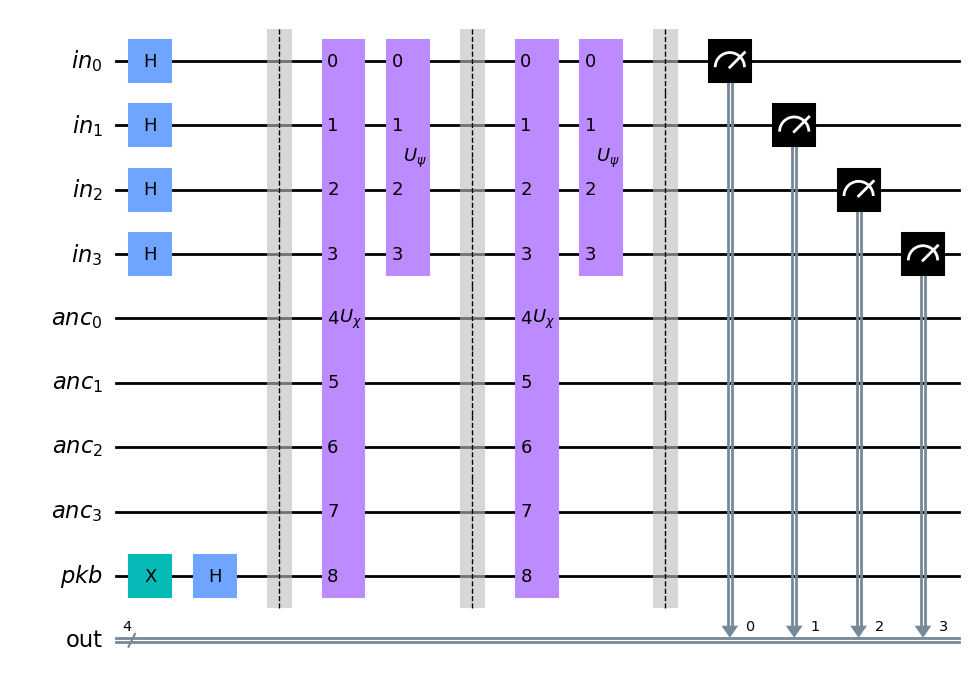

In [7]:
from qiskit.circuit.library import HGate

qubits = QuantumRegister(4, 'in')
ancillas = QuantumRegister(4, 'anc')
pkb = QuantumRegister(1, 'pkb')
output = ClassicalRegister(4, 'out')

circuit = QuantumCircuit(qubits, ancillas, pkb, output)

# prepare initial state
circuit.h(qubits)

# phase-kickback trick (S_\chi)
circuit.x(pkb)
circuit.h(pkb)

circuit.barrier()

for i in range(2):
    # S_\chi
    circuit.append(sudoku_oracle(), list(qubits) + list(ancillas) + list(pkb))
    # A^-1
    circuit.append(reflect_initial(HGate(), 4), qubits)
    circuit.barrier()

circuit.measure(qubits, output)
circuit.draw("mpl")

In [8]:
# circuit.decompose(["$U_\\chi$", "$U_\\psi$"]).decompose(["XORs", "XORs_dg", "$U_0$"]).draw("mpl")

In [9]:
backend = Aer.get_backend('aer_simulator')

{'1111': 3, '0100': 2, '1100': 3, '1000': 3, '0110': 478, '1101': 6, '1010': 2, '0111': 2, '0011': 5, '1011': 5, '1001': 485, '0101': 9, '1110': 5, '0010': 5, '0000': 6, '0001': 5}


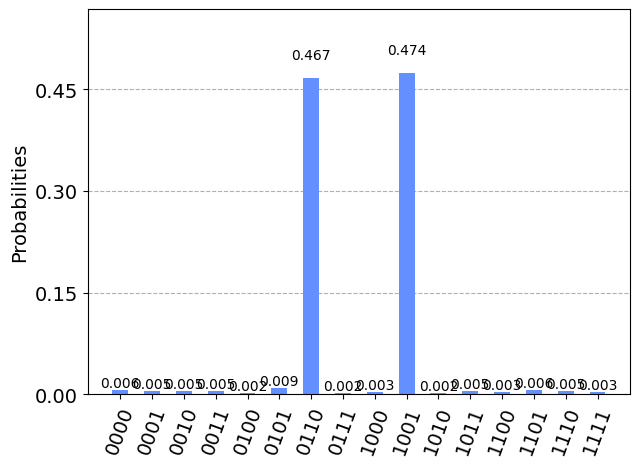

In [10]:
results = backend.run(transpile(circuit, backend)).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)